In [1]:
import numpy as np
import pandas as pd
import bisect
import matplotlib.pyplot as plt
from sklearn import tree
import time

D:\ProgramData\Anaconda3\envs\study_py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\ProgramData\Anaconda3\envs\study_py37\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\ProgramData\Anaconda3\envs\study_py37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class Node(object):
    def __init__(self):
        self.father = None
        self.left = None
        self.right = None
        self.split_point = None
        self.feature = None  # 记录当前节点划分特征索引值

    def __str__(self):
        return "feature: {}, split point: {}".format(self.feature, str(self.split_point))

    @property
    def is_leaf(self):
        return (self.left is None) and (self.right is None)

    @property
    def brother(self):
        if self.father is None:
            return None

        return self.father.left if (self.father.right is self) else self.father.right


class KNN(object):

    def __init__(self, k=5):
        self.k = k

        self.m = None
        self.n = None
        self.root = None

    def fit(self, X, y):
        '''

        :param X: numpy.array 类型
        :param y: numpy.array 类型
        :return:
        '''
        self.m, self.n = X.shape
        self.root = self._generate_kd(X, y)

        return self

    def predict(self, X):
        m = X.shape[0]
        result = np.empty((m,), dtype=int)

        for i in range(m):
            _, knn_node = self._knn_search(X[i, :], self.root)

            result[i] = np.argmax(np.bincount([nd.split_point[1] for nd in knn_node]))

        return result

    def _generate_kd(self, X, y, feature=0, father=None):

        m_, n_ = X.shape

        assert m_ == y.shape[0]

        # 空数据集表示当前节点为 None
        if m_ == 0:
            return None

        node = Node()
        node.father = father
        node.feature = feature

        # 只剩下一个样本时，直接设置为叶节点
        if m_ == 1:
            node.split_point = (X[0, :], y[0])
            return node

        # 获取当前特征的排名
        feature_rank = pd.Series(X[:, feature]).rank(method='first').astype(int)

        # 根据排名，获取中位数对应索引
        median_inx = feature_rank[feature_rank == m_ // 2].index[0]

        # 设置当前节点的数据点
        node.split_point = (X[median_inx, :], y[median_inx])

        left_inx = feature_rank < (m_ // 2)
        right_inx = feature_rank > (m_ // 2)

        # 生成子树
        node.left = self._generate_kd(X[left_inx, :], y[left_inx], (feature + 1) % self.n, node)
        node.right = self._generate_kd(X[right_inx, :], y[right_inx], (feature + 1) % self.n, node)

        return node

    def _get_leaf(self, x, node):
        '''
        根据 x ，以及 node 的节点划分特征向下搜索获取叶节点
        '''

        while node.is_leaf is not True:

            if node.left is None:
                node = node.right
            elif node.right is None:
                node = node.left
            else:
                if x[node.feature] < node.split_point[0][node.feature]:
                    node = node.left
                else:
                    node = node.right
        return node

    def _dist_to_node(self, x, node):
        '''
        计算 x 到节点数据点的距离
        '''
        return np.linalg.norm(x - node.split_point[0])

    def _dist_to_hyperplane(self, x, node):
        '''
        计算 x 到节点所处超平面的距离
        '''
        j = node.feature
        return abs(x[j] - node.split_point[0][j])

    def _insert_node(self, x, node, knn_dist, knn_node):
        """
        将当前节点数据插入 K 近邻集合
        """
        dist = self._dist_to_node(x, node)

        # bisect 是实现二分查找的内置模块， 返回应该插入的位置，这样保证 knn_dist 有序
        idx = bisect.bisect(knn_dist, dist)

        # 若 knn_dist 不足 k 个数据，则直接插入；若足够 k 个数据，且当前节点距离小于最大值，插入后丢弃最后一个数据
        if len(knn_dist) < self.k:
            knn_dist.insert(idx, dist)
            knn_node.insert(idx, node)
        elif knn_dist[-1] > dist:
            knn_dist.insert(idx, dist)
            knn_node.insert(idx, node)

            knn_dist = knn_dist[:-1]
            knn_node = knn_node[:-1]

        return knn_dist, knn_node

    def _knn_search(self, x, nd_root=None, knn_dist=None, knn_node=None):
        '''
        获取 K 个距离最近的节点，返回格式：[距离], [对应节点]
        '''
        if knn_dist is None:
            knn_dist = []
            knn_node = []

        # 当前 root 节点是否需要插入结果集
        knn_dist, knn_node = self._insert_node(x, nd_root, knn_dist, knn_node)

        nd_cur = self._get_leaf(x, nd_root)

        while nd_cur is not nd_root:

            # 当前节点插入结果集
            knn_dist, knn_node = self._insert_node(x, nd_cur, knn_dist, knn_node)

            # 当 knn_dist 集不足 k 个值，或者 x 距离当前节点超平面
            if ((nd_cur.brother is not None) and
                    ((len(knn_dist) < self.k) or (knn_dist[-1] > self._dist_to_hyperplane(x, nd_cur.father)))):
                knn_dist, knn_node = self._knn_search(x, nd_cur.brother, knn_dist, knn_node)

            nd_cur = nd_cur.father

        return knn_dist, knn_node


def plt_decision_bound(X_, y_, classifier, title):
    '''
    只针对西瓜书中数据，y 取值1, 0
    '''

    pos = y_ == 1
    neg = y_ == 0
    x_tmp = np.linspace(0.1, 0.8, 100)
    y_tmp = np.linspace(-0.1, 0.55, 100)

    X_tmp, Y_tmp = np.meshgrid(x_tmp, y_tmp)

    Z_ = classifier.predict(np.c_[X_tmp.ravel(), Y_tmp.ravel()]).reshape(X_tmp.shape)

    plt.contour(X_tmp, Y_tmp, Z_, [0.25, 0.5, 0.75], colors='orange', linewidths=1)

    plt.scatter(X_[pos, 0], X_[pos, 1], label='1', color='c')
    plt.scatter(X_[neg, 0], X_[neg, 1], label='0', color='lightcoral')

    plt.title(title)
    plt.legend()
    plt.show()

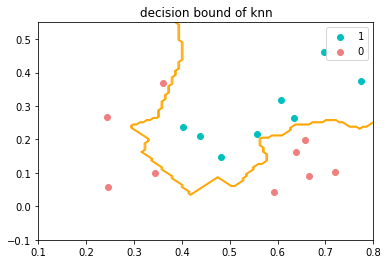

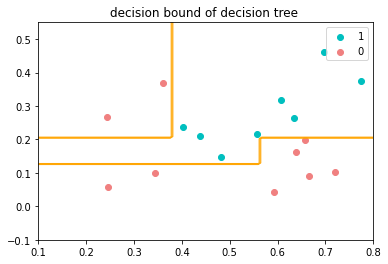

In [3]:
data_path = r'.\data_watermelon\watermelon3_0a_Ch.txt'

data = pd.read_table(data_path, delimiter=' ')

X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

knn = KNN(3)

# knn 决策边界
knn.fit(X, y)
plt_decision_bound(X, y, knn, 'decision bound of knn')

# print(y)
# print(knn.predict(X))


# 决策树决策边界
ds_tree = tree.DecisionTreeClassifier().fit(X, y)
plt_decision_bound(X, y, ds_tree, 'decision bound of decision tree ')